In [1]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

/kaggle/input/mlub2021-session8/train.txt
/kaggle/input/mlub2021-session8/test/test/test/test_composite000000426.png
/kaggle/input/mlub2021-session8/train/train/train/train_composite000012068.png


In [2]:
# others imports

import imageio
from skimage import transform,io
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers import Dropout, Flatten, Conv2D, MaxPool2D, Dense

from keras.layers import Dropout, Flatten, Conv2D, MaxPool2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator




In [3]:
np.random.seed(42)
tf.random.set_seed(42)
keras.backend.clear_session()

In [4]:
df_train = pd.read_csv('../input/mlub2021-session8/train.txt',sep=' ',header=None)
print(df_train.shape)

(15000, 2)


In [5]:
# take only the first 3000 images
#df_train = df_train.head(3000)

In [6]:
df_train

,0,1
0,/train/train_composite000000000.png,20
1,/train/train_composite000000001.png,18
2,/train/train_composite000000002.png,7
3,/train/train_composite000000003.png,18
4,/train/train_composite000000004.png,17
...,...,...
14995,/train/train_composite000014995.png,22
14996,/train/train_composite000014996.png,7
14997,/train/train_composite000014997.png,2
14998,/train/train_composite000014998.png,29


In [7]:
df_train.describe()

,1
count,15000.000000
mean,14.377067
std,8.655134
min,0.000000
25%,7.000000
50%,14.000000
75%,22.000000
max,29.000000


In [8]:
data_dir = '../input/mlub2021-session8/train/train/'

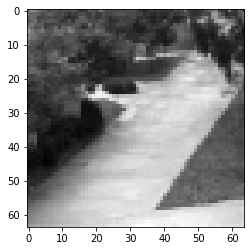

In [9]:
# extracted from theory notebooks
# read images and store into a np array

im_size = 64
N = df_train.shape[0]
X = np.zeros((N, im_size,im_size))
y = np.zeros((N))
cont = 0

for ind, item in df_train.iterrows():
    im       = imageio.imread(data_dir + item[0])/255. 
    small_im = transform.resize(im, (im_size,im_size), mode='symmetric', preserve_range=True)
    X[cont, :,:] = small_im
    y[cont] = item[1]
    cont += 1
    
plt.imshow(small_im,cmap='gray')
plt.show()

For generating more images I used the lib:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [10]:
data_generator = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = "nearest")

Generate train and test

In [11]:
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.3, random_state=66)

In [12]:
# add 1 at the end to match input_shape of the model
X_train = X_train.reshape(X_train.shape + (1,))
X_val = X_val.reshape(X_val.shape + (1,))

Generate the network model

In [13]:
# best model i tried
model = keras.models.Sequential()
model.add(Conv2D(filters=32, kernel_size=5, padding="same", activation="relu", input_shape=[64, 64, 1]))
model.add(MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="linear"))

2022-01-11 12:21:35.444456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 12:21:35.532118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 12:21:35.532819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 12:21:35.533989: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [15]:
model.layers

In [16]:
model.compile(loss="mean_squared_error", optimizer="Adam",metrics=["mean_squared_error",tf.keras.metrics.MeanAbsoluteError()])

In [17]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
check_pointer = ModelCheckpoint(filepath = "my_keras_model.h5", save_best_only=True)

In [18]:
history = model.fit(data_generator.flow(X_train, y_train, batch_size=64),steps_per_epoch=len(X_train) // 64, 
                    epochs=200, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping_cb, check_pointer])

2022-01-11 12:21:38.145772: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-01-11 12:21:39.475395: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


164/164 [==============================] - 12s 34ms/step - loss: 64.4518 - mean_squared_error: 64.4518 - mean_absolute_error: 6.5991 - val_loss: 35.5774 - val_mean_squared_error: 35.5774 - val_mean_absolute_error: 4.9545
Epoch 2/200
164/164 [==============================] - 6s 37ms/step - loss: 15.9387 - mean_squared_error: 15.9387 - mean_absolute_error: 3.1090 - val_loss: 11.9183 - val_mean_squared_error: 11.9183 - val_mean_absolute_error: 2.7321
Epoch 3/200
164/164 [==============================] - 6s 35ms/step - loss: 13.3519 - mean_squared_error: 13.3519 - mean_absolute_error: 2.8568 - val_loss: 16.1875 - val_mean_squared_error: 16.1875 - val_mean_absolute_error: 3.2388
Epoch 4/200
164/164 [==============================] - 6s 35ms/step - loss: 10.9359 - mean_squared_error: 10.9359 - mean_absolute_error: 2.5465 - val_loss: 6.0825 - val_mean_squared_error: 6.0825 - val_mean_absolute_error: 1.8924
Epoch 5/200
164/164 [==============================] - 6s 35ms/step - loss: 8.5303 - 

In [19]:
# resize test files
test_dir = '../input/mlub2021-session8/test/test/test/'
im_size = 64
N = 500
X_test = np.zeros((N, im_size,im_size))
cont = 0

for x in range(500):
    im       = imageio.imread(test_dir + 'test_composite'+str(x).zfill(9) + '.png')/255.
    small_im = transform.resize(im, (im_size,im_size), mode='symmetric', preserve_range=True)
    X_test[cont, :,:] = small_im
    cont += 1

In [20]:
X_test = X_test.reshape(500, 64, 64, 1)
# predict and submit

y_test = model.predict(X_test)
y_test = [int(x[0]) for x in y_test]

df_output = pd.DataFrame(y_test)
df_output.index.name = 'index'
df_output.columns = ['prediction']
df_output.to_csv('output.csv')

